# Evaluation of CosmoFlow training runs

This notebook demonstrates how to evaluate multiple training runs together on some plots and in a summary table.

You will just need to update the result directory paths.

In [1]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/benchmarks/cosmoflow-benchmark/notebooks'

In [2]:
import os
import sys
import yaml
import pickle

sys.path.append('..')

In [3]:
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
from models import get_model
from data.cosmo import construct_dataset
from utils.optimizers import get_optimizer

In [5]:
%matplotlib inline

In [6]:
plt.rcParams.update({'font.size': 14})

## Summary utility functions

In [7]:
def load_config(result_dir):
    config_file = os.path.join(result_dir, 'config.pkl')
    with open(config_file, 'rb') as f:
        return pickle.load(f)

def load_history(result_dir):
    print('loading', result_dir)
    history_file = os.path.join(result_dir, 'history.csv')
    return pd.read_csv(history_file)

def make_summary(h, c, target_mae=None):
    best_epoch = h.epoch.loc[h.val_loss.idxmin()]
    summary = dict(
        name = os.path.basename(c['output_dir']),
        ranks = c['n_ranks'],
        global_batch = c['n_ranks'] * c['data']['batch_size'],
        epoch_time = h.time.median() / 60,
        epochs = len(h),
        best_epoch = best_epoch,
        best_mae = h.val_mean_absolute_error.loc[best_epoch]
    )
    if target_mae is not None and h.val_mean_absolute_error.min() < target_mae:
        target_epoch = h[h.val_mean_absolute_error < target_mae].index[0]
        target_time = h.time.loc[:target_epoch].sum() / 60.
        summary.update(target_mae=target_mae, target_epoch=target_epoch, target_time=target_time)
    return summary

def make_summary_table(histories, configs, target_mae=None):
    return pd.DataFrame([
        make_summary(h, c, target_mae) for (h, c) in zip(histories, configs)
    ])

def summary_report(result_dirs, target_mae=None, epoch_max=None, mean_window_size=1):
    
    # Load the histories, configs, summaries
    histories = [load_history(d) for d in result_dirs]
    configs = [load_config(d) for d in result_dirs]
    summary = make_summary_table(histories, configs, target_mae)
    
    # Setup the figure
    fig, ((ax_mse, ax_mae), (ax_lr, ax_time)) = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))
    
    # Fill the plots
    for i, h in enumerate(histories):
        label = os.path.basename(result_dirs[i])
        ax_mse.plot(h.loss.rolling(mean_window_size, min_periods=1).mean(),
                    '--', color=f'C{i}')
        ax_mse.plot(h.val_loss.rolling(mean_window_size, min_periods=1).mean(),
                    '-', color=f'C{i}', label=label)
        ax_mae.plot(h.mean_absolute_error.rolling(mean_window_size, min_periods=1).mean(),
                    '--', color=f'C{i}')
        ax_mae.plot(h.val_mean_absolute_error.rolling(mean_window_size, min_periods=1).mean(),
                    '-', color=f'C{i}', label=label)
        ax_lr.plot(h.lr, label=label)
        ax_time.plot(h.time/60, label=label)

    # Plot the target
    if target_mae is not None:
        epoch_range = [0, max(len(h) for h in histories)]
        ax_mae.plot(epoch_range, [target_mae, target_mae], '--', color='black', label=f'target: {target_mae}')
    
    if epoch_max is not None:
        for ax in [ax_mse, ax_mae, ax_lr, ax_time]:
            ax.set_xlim(right=epoch_max)

    # Finalize the plots
    ax_mse.set_xlabel('Epoch')
    ax_mse.set_ylabel('Mean squared error')
    ax_mse.legend(loc=0)
    ax_mse.grid()
    
    #ax_mae.set_yscale('log')
    ax_mae.set_xlabel('Epoch')
    ax_mae.set_ylabel('Mean absolute error')
    ax_mae.legend(loc=0)
    ax_mae.grid()
    
    ax_lr.set_xlabel('Epoch')
    ax_lr.set_ylabel('Learning rate')
    ax_lr.legend(loc=0)
    ax_lr.grid()
    
    ax_time.set_xlabel('Epoch')
    ax_time.set_ylabel('Epoch time [min]')
    ax_time.legend(loc=0)
    ax_time.grid()

    plt.tight_layout()
    
    return summary, histories, configs

## Specify the results to display

In [8]:
result_dirs = []

In [9]:
result_dirs += [
    # Baseline results with batch 64 on 64 GPUs
    '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cgpu-2020-06-28-n64',
    '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cgpu-2020-06-30-n64',
    '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cgpu-2020-07-02-n64',
    '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cgpu-2020-07-03-n64',
    '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cgpu-2020-07-04-n64',
]

## Make the report

loading /global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cgpu-2020-06-28-n64
loading /global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cgpu-2020-06-30-n64
loading /global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cgpu-2020-07-02-n64
loading /global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cgpu-2020-07-03-n64
loading /global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cgpu-2020-07-04-n64


,name,ranks,global_batch,epoch_time,epochs,best_epoch,best_mae,target_mae,target_epoch,target_time
0,cgpu-2020-06-28-n64,64,64,5.252846,128,105,0.118819,0.124,51,273.336078
1,cgpu-2020-06-30-n64,64,64,5.254823,128,115,0.119450,0.124,46,244.287250
2,cgpu-2020-07-02-n64,64,64,5.218203,128,119,0.119786,0.124,54,286.212857
3,cgpu-2020-07-03-n64,64,64,5.199611,128,102,0.121216,0.124,56,299.630111
4,cgpu-2020-07-04-n64,64,64,5.222523,128,112,0.118983,0.124,43,231.433965


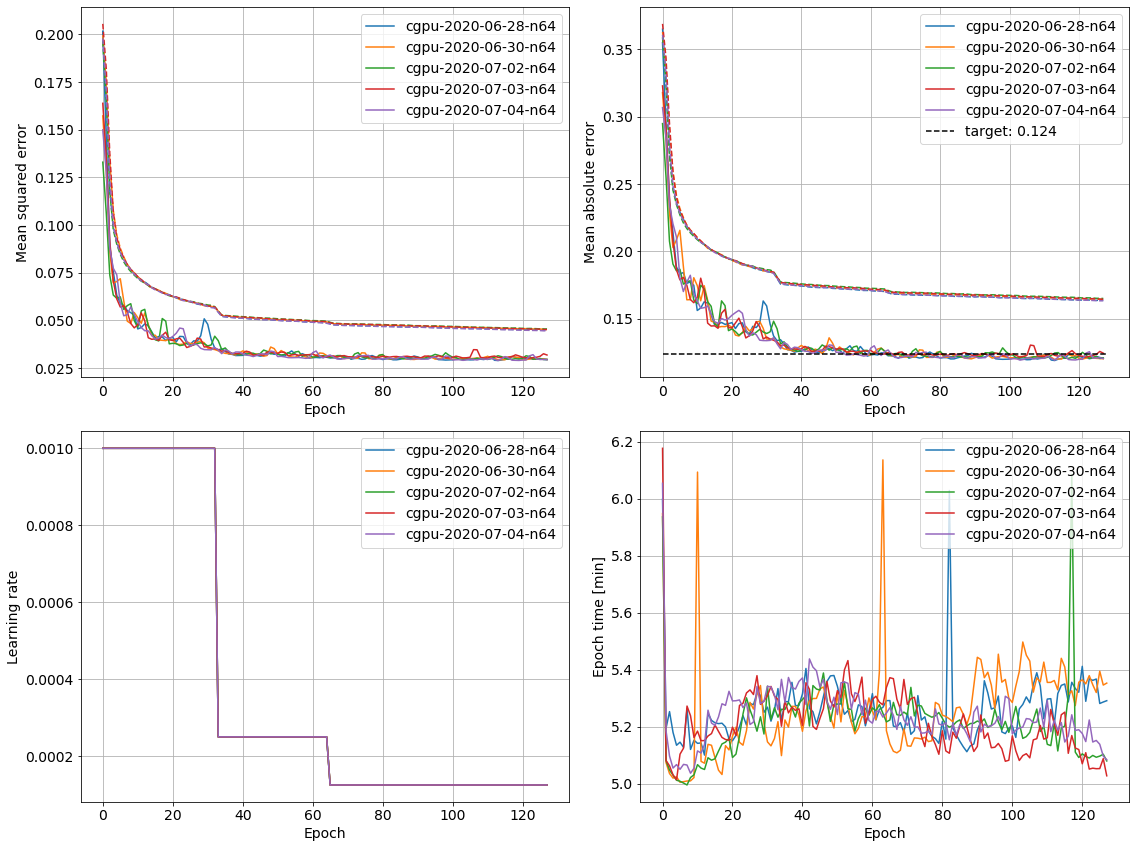

In [10]:
summary, histories, configs = summary_report(result_dirs, target_mae=0.124, mean_window_size=2)
summary

In [11]:
summary.target_time.std() / summary.target_time.mean()

0.1068450152478821